In [2]:
# use wandb artifact outside a run

import wandb

api = wandb.Api()
artifact = api.artifact('greatml/FedSPK/Artifact0.8790510733321198:v0')

datadir = artifact.download()


wandb:   1 of 1 files downloaded.  


In [3]:
def loadParameters(model, path, map_location="cuda:0"):

    self_state = model.state_dict()
    loaded_state = torch.load(path, map_location=map_location)

    for name, param in loaded_state.items():
        if '__L__.W' in name:
            continue

        origname = name
        if name not in self_state:
            name = name.replace("module.", "")
            if name not in self_state:
                name = "__S__."+name
                if name not in self_state:
                    print("#%s is not in the model." % origname)
                    continue

        if self_state[name].size() != loaded_state[origname].size():
            print("#Wrong parameter length: %s, model: %s, loaded: %s" % (
                origname, self_state[name].size(), loaded_state['model'][origname].size()))
            continue

        self_state[name].copy_(param)


In [4]:
# %%
import time
from src.DatasetLoader import loadWAV
import os
import sys


def evaluateFromList(model, listfilename, print_interval=100, test_path='', num_eval=10, eval_frames=0, verbose=True):

    model = model.cuda()

    model.eval()

    labels = []
    files = []
    feats = []
    tstart = time.time()

    # Read all lines
    with open(listfilename) as listfile:
        while True:
            line = listfile.readline()
            if (not line):
                break

            data = line.split()

            files.append(data[1])
            labels.append(data[0])

    f_labels = []
    # Save all features to file
    for idx, (file, label) in enumerate(zip(files, labels)):

        inp1 = torch.FloatTensor(loadWAV(os.path.join(
            test_path, file), eval_frames, evalmode=True, num_eval=num_eval)).cuda()

        try:
            ref_feat = model.forward(inp1).detach().cpu()
        except:
            print("Error in file: ", file)
            continue

        feats.append(ref_feat)
        f_labels.append(label)

        telapsed = time.time() - tstart

        if (idx % print_interval == 0) and verbose:
            sys.stdout.write("\rReading %d of %d: %.2f Hz, embedding size %d" % (
                idx, len(files), idx/telapsed, ref_feat.size()[1]))

    tstart = time.time()

    return feats, f_labels


In [5]:
# %%
# load the pytorch model

import torch

loaded_state = torch.load(
    datadir + '/STD: std_FL test compact testing, canoical.pth', map_location='cpu')


In [5]:
# %%
from src.SpeakerNet import SpeakerNet

model = SpeakerNet(model='X_vector', trainfunc='softmax', nPerSpeaker=1, Syncbatch=False,
                   n_mels=40, nOut=192, spec_aug=False, nClasses=5994, additional_model=[True, False], ID_task=40)


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


In [7]:
# %%
loadParameters(model, datadir +
               '/STD: std_FL test compact testing, canoical.pth')


In [2]:
# pytorch softmax function demo

import torch.nn.functional as F
import torch


x = torch.randn(2, 3)
print(x)
print(F.softmax(x, dim=1))


tensor([[-0.6140, -1.7953, -0.7002],
        [-0.4306,  0.6658, -0.3207]])
tensor([[0.4496, 0.1380, 0.4125],
        [0.1957, 0.5858, 0.2184]])


In [4]:
import torch.nn as nn

fc = nn.Linear(3, 5)

fc(x)


tensor([[ 1.0797, -1.3248, -0.8251,  0.4565,  1.3985],
        [-0.3997,  0.0221,  0.1411,  0.1974,  0.0455]],
       grad_fn=<AddmmBackward0>)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.541


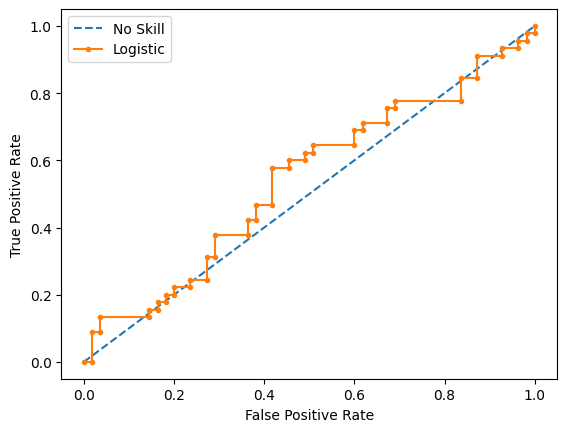

In [1]:
# draw binary classification roc curve demo
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate random y_test
from numpy import random
y_test = random.randint(2, size=100)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
# lr_probs = model.predict_proba(X_test)

# generate random lr_probs
lr_probs = random.rand(len(y_test), 2)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


In [ ]:
# draw binary classification curve demo
import numpy as np
import matplotlib.pyplot as plt


def draw_binary_classification_curve_demo():
    # generate 2 class dataset
    mean1 = [1, 20]
    cov1 = [[1, 1], [1, 2]]
    x1, y1 = np.random.multivariate_normal(mean1, cov1, 1000).T
    mean2 = [20, 1]
    cov2 = [[2, 1], [1, 1]]
    x2, y2 = np.random.multivariate_normal(mean2, cov2, 1000).T

    # draw scatter plot
    plt.scatter(x1, y1, c='r', marker='x')
    plt.scatter(x2, y2, c='b', marker='o')

    # draw binary classification curve
    x = np.linspace(0, 20, 100)
    y = 0.5 * x + 10
    plt.plot(x, y, c='g')

    plt.show()


In [ ]:
# # %%
# import pickle

# for i in range(12):
#     feats, labels = evaluateFromList(model, "../flearn_data/G%d_ID/train_list_G%d_ID.txt"%(i+1,i+1))

#     # save python objects feats and labels
#     with open('../FL_log/feats_G%d_ID.pkl'%i, 'wb') as f:
#         pickle.dump(feats, f)
#     with open('../FL_log/labels_G%d_ID.pkl'%i, 'wb') as f:
#         pickle.dump(labels, f)
